# Explore Covid-19 data across the US

This notebook explores the Covid-19 dataset available as part of Google BigQuery public data. This notebook explores two tables the us_states and the us_counties which contain the per data confirmed cases and deaths across states and counties.

We first install the neccessary Python packages needed for the analysis and then pull the data from BigQuery directly into a Python Pandas dataframe. The data is then analyzed using Pandas and visulized using Plotly.

## Install the dependencies

In [94]:
!pip install --upgrade google-cloud-bigquery[pandas]
!pip install plotly
!pip install seaborn

Requirement already up-to-date: google-cloud-bigquery[pandas] in /opt/conda/lib/python3.7/site-packages (1.25.0)


In [95]:
import plotly
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Download the data from BigQuery
We download the states data into a dataframe named covid_us_states and similarly for counties in a dataframe named covid_us_counties. We also run a query to download the data for daily changes i.e. new cases confirmed and new deaths reported.

In [96]:
%%bigquery covid_us_states
SELECT
    *
FROM `bigquery-public-data.covid19_nyt.us_states`
ORDER BY date DESC

In [97]:
%%bigquery covid_us_counties
SELECT
    *
FROM `bigquery-public-data.covid19_nyt.us_counties`
ORDER BY date DESC

In [98]:
%%bigquery covid_us_states_daily_changes
SELECT
  *,
  LAG(deaths) OVER (PARTITION BY state_name ORDER BY date ASC) AS deaths_yesterday,
  (deaths-LAG(deaths) OVER (PARTITION BY state_name ORDER BY date ASC)) as new_deaths,
  LAG(confirmed_cases) OVER (PARTITION BY state_name ORDER BY date ASC) AS confirmed_cases_yesterday,
  (confirmed_cases-LAG(confirmed_cases) OVER (PARTITION BY state_name ORDER BY date ASC)) as new_confirmed_cases
FROM
  `bigquery-public-data.covid19_nyt.us_states`

## Let's explore the data a little bit

In [99]:
display(covid_us_states.sample(10))
covid_us_states.describe(include='all')

,date,state_name,state_fips_code,confirmed_cases,deaths
5657,2020-03-29,Massachusetts,25,4955,48
4183,2020-04-24,Utah,49,3782,39
5992,2020-03-22,Ohio,39,351,3
1730,2020-06-08,Maryland,24,59024,2776
3071,2020-05-15,South Dakota,46,3887,44
4210,2020-04-24,Oklahoma,40,3120,188
581,2020-06-29,Virginia,51,62189,1740
3526,2020-05-06,Texas,48,35441,985
4921,2020-04-11,Michigan,26,23855,1395
5243,2020-04-05,Vermont,50,512,22


,date,state_name,state_fips_code,confirmed_cases,deaths
count,7109,7109,7109,7109.000000,7109.000000
unique,171,55,55,NaN,NaN
top,2020-04-01,Washington,53,NaN,NaN
freq,55,171,171,NaN,NaN
mean,NaN,NaN,NaN,22178.199887,1178.492334
std,NaN,NaN,NaN,49459.003818,3479.841085
min,NaN,NaN,NaN,1.000000,0.000000
25%,NaN,NaN,NaN,511.000000,7.000000
50%,NaN,NaN,NaN,4586.000000,129.000000
75%,NaN,NaN,NaN,21422.000000,786.000000


In [100]:
display(covid_us_counties.sample(10))
covid_us_counties.describe(include='all')

,date,county,state_name,county_fips_code,confirmed_cases,deaths
206076,2020-05-02,Grainger,Tennessee,47057,6,0
216098,2020-04-28,Van Buren,Iowa,19177,8,0
112094,2020-06-03,Cumberland,Tennessee,47035,119,1
274153,2020-04-07,Seward,Nebraska,31159,1,0
81003,2020-06-13,Benton,Mississippi,28009,17,0
125572,2020-05-29,Mitchell,Iowa,19131,4,0
65051,2020-06-18,Twin Falls,Idaho,16083,504,26
143093,2020-05-23,Whitfield,Georgia,13313,270,7
131872,2020-05-27,Barnstable,Massachusetts,25001,1286,111
302036,2020-03-25,Logan,Ohio,39091,2,0


,date,county,state_name,county_fips_code,confirmed_cases,deaths
count,313349,313349,313349,310087,313349.000000,313349.000000
unique,171,1814,55,3065,NaN,NaN
top,2020-07-08,Washington,Texas,53061,NaN,NaN
freq,3095,3352,22902,171,NaN,NaN
mean,NaN,NaN,NaN,NaN,503.163731,26.736387
std,NaN,NaN,NaN,NaN,4143.054494,359.554671
min,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,6.000000,0.000000
50%,NaN,NaN,NaN,NaN,30.000000,1.000000
75%,NaN,NaN,NaN,NaN,146.000000,4.000000


In [101]:
covid_us_counties['county'] = covid_us_counties.apply(lambda row: row['county'] + ", " + row['state_name'], axis=1)
covid_us_counties['county_fips_code'] = covid_us_counties['county_fips_code'].map(lambda x: int(x) if x is not None else 0)

## Time for some plots

We will create choropleth maps showing the the spread of covid-19 across different states. We will then normalize it based on population.

In [102]:
# county names are not unique, append state names.
covid_us_counties['county'] = covid_us_counties.apply(lambda row: row['county'] + ", " + row['state_name'], axis=1)
covid_us_counties['county_fips_code'] = covid_us_counties['county_fips_code'].map(lambda x: int(x) if x is not None else 0)
covid_us_counties.head()

,date,county,state_name,county_fips_code,confirmed_cases,deaths
0,2020-07-09,"Joplin, Missouri, Missouri",Missouri,0,247,13
1,2020-07-09,"Kansas City, Missouri, Missouri",Missouri,0,2957,35
2,2020-07-09,"New York City, New York, New York",New York,0,222723,22719
3,2020-07-09,"Unknown, Guam, Guam",Guam,0,1278,6
4,2020-07-09,"Unknown, Iowa, Iowa",Iowa,0,22,0


The data that we have is cumulative for each day, to display the current status (confirmed cases & deaths) we need to filter out everything except the data for latest date. 

Also, there are more than 3000 counties, for the bar chart we will display the top 20 (by confirmed cases).

In [103]:
covid_us_counties_latest = covid_us_counties[covid_us_counties['date']==max(covid_us_counties['date'])]
covid_us_states_latest = covid_us_states[covid_us_states['date']==max(covid_us_states['date'])]

# it is slightly cumbersome to have plotly sort the dataset while rendering the chart so we do out before drawing the chart
covid_us_states_latest = covid_us_states_latest.sort_values(by="confirmed_cases", ascending=False)
covid_us_counties_latest = covid_us_counties_latest.sort_values(by="confirmed_cases", ascending=False)
TOP_N = 20
covid_us_counties_latest_top_n = covid_us_counties_latest[:TOP_N]

### State wise confirmed cases and deaths

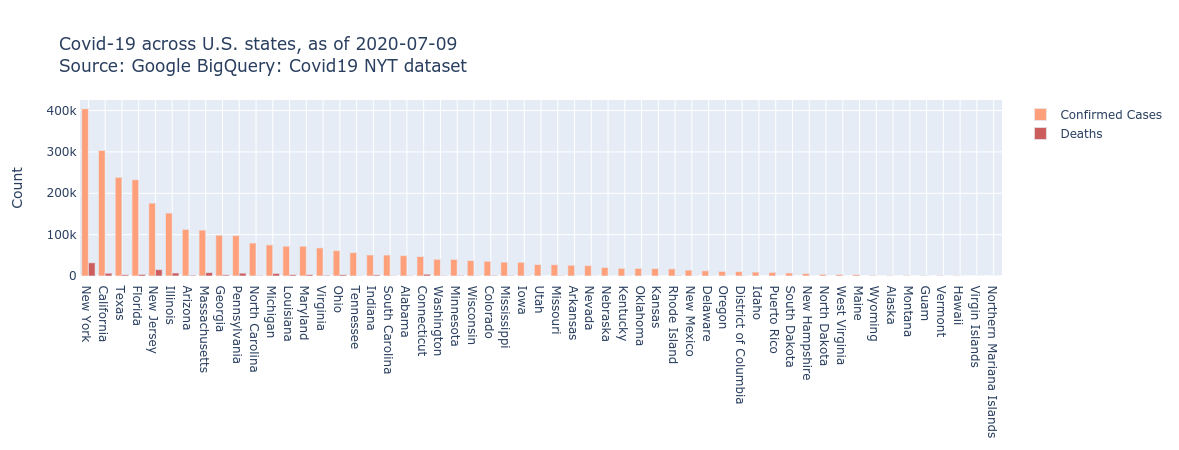

In [104]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    x=covid_us_states_latest['state_name'],
    y=covid_us_states_latest['confirmed_cases'],
    name='Confirmed Cases',
    marker_color='lightsalmon'
))
fig.add_trace(go.Bar(
    x=covid_us_states_latest['state_name'],
    y=covid_us_states_latest['deaths'],
    name='Deaths',
    marker_color='indianred'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group',
                  title=f"Covid-19 across U.S. states, as of {covid_us_states_latest.iloc[0]['date']}<br>Source: Google BigQuery: Covid19 NYT dataset",
                  yaxis_title="Count")
fig.show()

### County wise confirmed cases and deaths

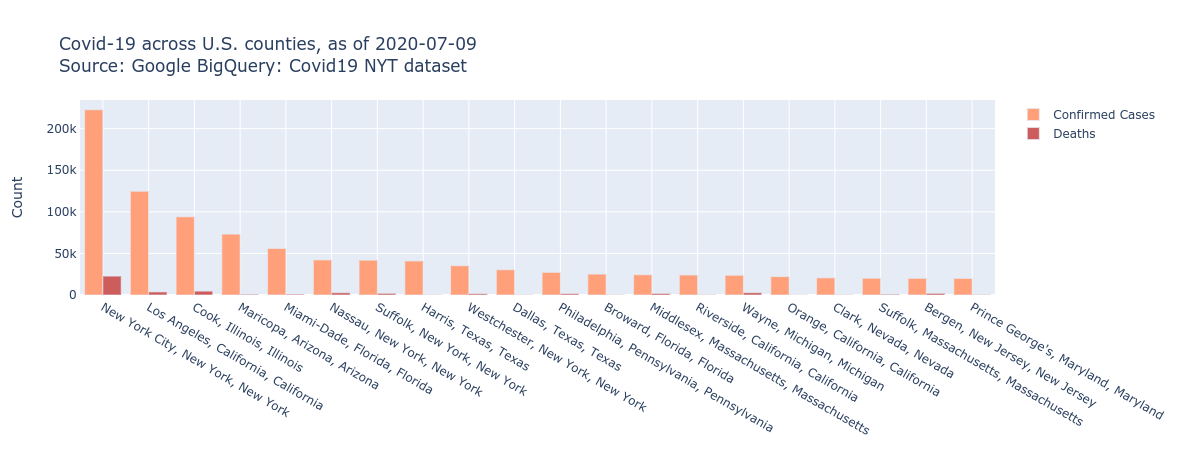

In [105]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    x=covid_us_counties_latest_top_n['county'],
    y=covid_us_counties_latest_top_n['confirmed_cases'],
    name='Confirmed Cases',
    marker_color='lightsalmon'
))
fig.add_trace(go.Bar(
    x=covid_us_counties_latest_top_n['county'],
    y=covid_us_counties_latest_top_n['deaths'],
    name='Deaths',
    marker_color='indianred'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group',
                  title=f"Covid-19 across U.S. counties, as of {covid_us_counties_latest_top_n.iloc[0]['date']}<br>Source: Google BigQuery: Covid19 NYT dataset",
                  yaxis_title="Count")
fig.show()

### Maps
We plot the confirmed cases by state as heatmap. The darker the color the more the cases.

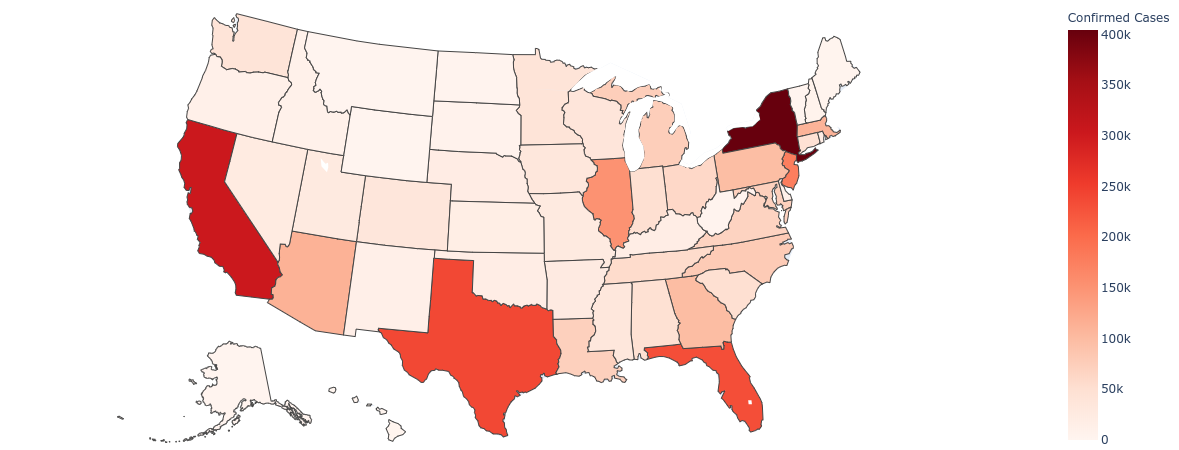

In [106]:
from urllib.request import urlopen
import plotly.express as px
import json

with urlopen('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json') as response:
    states = json.load(response)


fig = px.choropleth(covid_us_states_latest, geojson=states, locations='state_fips_code', color='confirmed_cases',
                           color_continuous_scale="Reds",
                           range_color=(0, max(covid_us_states['confirmed_cases'])),
                           scope="usa",
                           hover_name="state_name",
                           labels={'confirmed_cases':'Confirmed Cases'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

But this did not give the real picture, what we should be comparing is the number of deaths normalized by population. We download the state population dataset and then normalzie the cases and deaths by per 10,000 people.

In [107]:
states_census = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv?#")
display(states_census.head(10))

,SUMLEV,REGION,DIVISION,STATE,NAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,10,0,0,0,United States,308745538,308758105,309321666,311556874,313830990,...,0.000000,2.493773,2.682083,2.636187,2.921500,3.260435,3.252788,2.871957,2.153911,1.818059
1,20,1,0,0,Northeast Region,55317240,55318443,55380134,55604223,55775216,...,-5.254530,0.887909,-0.038355,-0.469783,-0.986097,-2.061965,-2.490484,-1.837048,-2.134447,-2.859713
2,20,2,0,0,Midwest Region,66927001,66929725,66974416,67157800,67336743,...,-2.365881,-0.963930,-0.973943,-0.006924,-0.762969,-1.388437,-1.241784,-0.557370,-0.922755,-1.111173
3,20,3,0,0,South Region,114555744,114563030,114866680,116006522,117241208,...,3.261349,5.130513,5.850458,5.292073,6.161501,7.277358,7.150074,6.198168,5.225519,5.203720
4,20,4,0,0,West Region,71945553,71946907,72100436,72788329,73477823,...,0.614245,2.723344,3.062896,3.162262,4.026429,4.987285,5.261078,4.021194,3.044951,2.312083
5,40,3,6,1,Alabama,4779736,4780125,4785437,4799069,4815588,...,1.917501,0.578434,1.186314,1.522549,0.563489,0.626357,0.745172,1.090366,1.773786,2.483744
6,40,4,9,2,Alaska,710231,710249,713910,722128,730443,...,-12.929847,0.587728,1.416798,-0.955359,-11.460949,-7.997118,-3.897349,-10.992765,-13.859140,-12.031221
7,40,4,8,4,Arizona,6392017,6392288,6407172,6472643,6554978,...,12.609078,4.278167,6.899802,6.376679,9.168478,9.597577,11.964782,10.878879,12.962934,13.687161
8,40,3,7,5,Arkansas,2915918,2916031,2921964,2940667,2952164,...,0.834503,3.294766,0.827785,0.057853,-0.091449,1.075446,1.486269,2.009593,0.958896,0.923429
9,40,4,9,6,California,37253956,37254519,37319502,37638369,37948800,...,-5.151429,1.276797,1.495016,1.649031,2.203551,1.984957,0.500044,-0.629909,-2.130954,-3.276681


Join the population data with the Covid data. We use the estimated population for 2019 from the census data.

In [108]:
covid_us_states_latest_w_census_data = covid_us_states_latest.merge(states_census[['POPESTIMATE2019', 'NAME']], how="left", left_on="state_name", right_on="NAME")
covid_us_states_latest_w_census_data = covid_us_states_latest_w_census_data.dropna()
covid_us_states_latest_w_census_data['deaths_per_10k'] = covid_us_states_latest_w_census_data.apply(lambda x: int(10000*(x['deaths']/x['POPESTIMATE2019'])), axis=1)
covid_us_states_latest_w_census_data['confirmed_cases_per_10k'] = covid_us_states_latest_w_census_data.apply(lambda x: int(10000*(x['confirmed_cases']/x['POPESTIMATE2019'])), axis=1)

covid_us_states_latest_w_census_data.head()

,date,state_name,state_fips_code,confirmed_cases,deaths,POPESTIMATE2019,NAME,deaths_per_10k,confirmed_cases_per_10k
0,2020-07-09,New York,36,404207,31979,19453561.0,New York,16,207
1,2020-07-09,California,06,303448,6825,39512223.0,California,1,76
2,2020-07-09,Texas,48,238614,3016,28995881.0,Texas,1,82
3,2020-07-09,Florida,12,232710,4008,21477737.0,Florida,1,108
4,2020-07-09,New Jersey,34,176217,15448,8882190.0,New Jersey,17,198


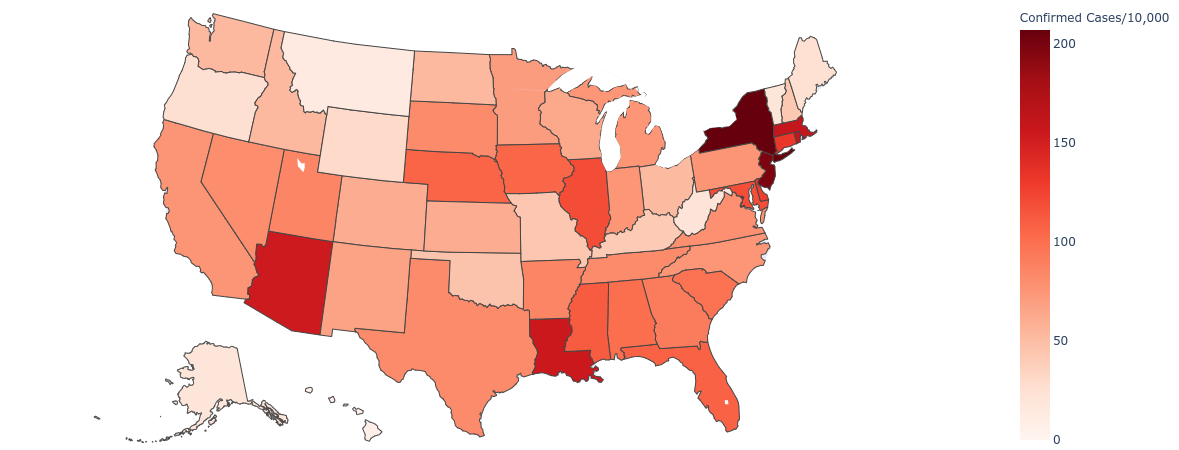

In [109]:

with urlopen('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json') as response:
    states = json.load(response)
fig = px.choropleth(covid_us_states_latest_w_census_data, geojson=states, locations='state_fips_code', color='confirmed_cases_per_10k',
                           #color_continuous_scale=px.colors.sequential.Plasma,
                           color_continuous_scale="Reds",
                           range_color=(0, max(covid_us_states_latest_w_census_data['confirmed_cases_per_10k'])),
                           scope="usa" ,
                           hover_name="state_name",
                           labels={'confirmed_cases_per_10k':'Confirmed Cases/10,000'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


In [110]:
covid_us_states_daily_changes

,date,state_name,state_fips_code,confirmed_cases,deaths,deaths_yesterday,new_deaths,confirmed_cases_yesterday,new_confirmed_cases
0,2020-03-13,Alabama,01,6,0,NaN,NaN,NaN,NaN
1,2020-03-14,Alabama,01,12,0,0.0,0.0,6.0,6.0
2,2020-03-15,Alabama,01,23,0,0.0,0.0,12.0,11.0
3,2020-03-16,Alabama,01,29,0,0.0,0.0,23.0,6.0
4,2020-03-17,Alabama,01,39,0,0.0,0.0,29.0,10.0
...,...,...,...,...,...,...,...,...,...
7104,2020-07-05,Wyoming,56,1634,20,20.0,0.0,1606.0,28.0
7105,2020-07-06,Wyoming,56,1675,20,20.0,0.0,1634.0,41.0
7106,2020-07-07,Wyoming,56,1711,21,20.0,1.0,1675.0,36.0
7107,2020-07-08,Wyoming,56,1740,21,21.0,0.0,1711.0,29.0


### Compare Repubican Vs Democratic states
We find out correlation between the confirmed cases timeseries for all states and then evaluate which states were similar and which were different.
1. Do all Republican states look alike in terms of number of confirmed cases?
2. Do all Democratic states look alike? 
3. Do some states even though Republican look Democratic (and vice-versa)? 


In [111]:
covid_us_states_daily_changes_wide = covid_us_states_daily_changes[['date', 'state_name', 'new_confirmed_cases']].pivot(index='date', columns='state_name',values='new_confirmed_cases').reset_index(drop=True)
covid_us_states_wide = covid_us_states_daily_changes_wide.fillna(0)
covid_us_states_daily_changes_wide.to_csv('covid_us_states_daily_changes_wide.csv', index=False)
covid_us_states_daily_changes_wide = pd.read_csv('covid_us_states_daily_changes_wide.csv')
covid_us_states_daily_changes_wide

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,1091.0,32.0,3510.0,605.0,6411.0,200.0,0.0,132.0,35.0,10059.0,...,1133.0,4430.0,288.0,11.0,1.0,639.0,669.0,130.0,507.0,28.0
167,925.0,30.0,3416.0,439.0,6282.0,216.0,259.0,165.0,33.0,6336.0,...,1144.0,9213.0,648.0,2.0,0.0,354.0,1049.0,107.0,568.0,41.0
168,907.0,22.0,3617.0,259.0,9897.0,401.0,57.0,121.0,54.0,7347.0,...,1134.0,9814.0,550.0,3.0,10.0,638.0,546.0,63.0,516.0,36.0
169,1177.0,49.0,3551.0,734.0,8538.0,468.0,75.0,48.0,73.0,9989.0,...,2113.0,9952.0,718.0,2.0,22.0,635.0,598.0,202.0,692.0,29.0


### Texas Vs Florida?
We compare two red states, texas and Florida. We first see the timeseries of daily new confirmed cases in the two states so that we can visually see if they are similar, we can then plot them against each other to see if we get a straight line at 45 degrees (perfect correlation) and then finally we determine a statistical correlation.

**Please see https://realpython.com/numpy-scipy-pandas-correlation-python/**

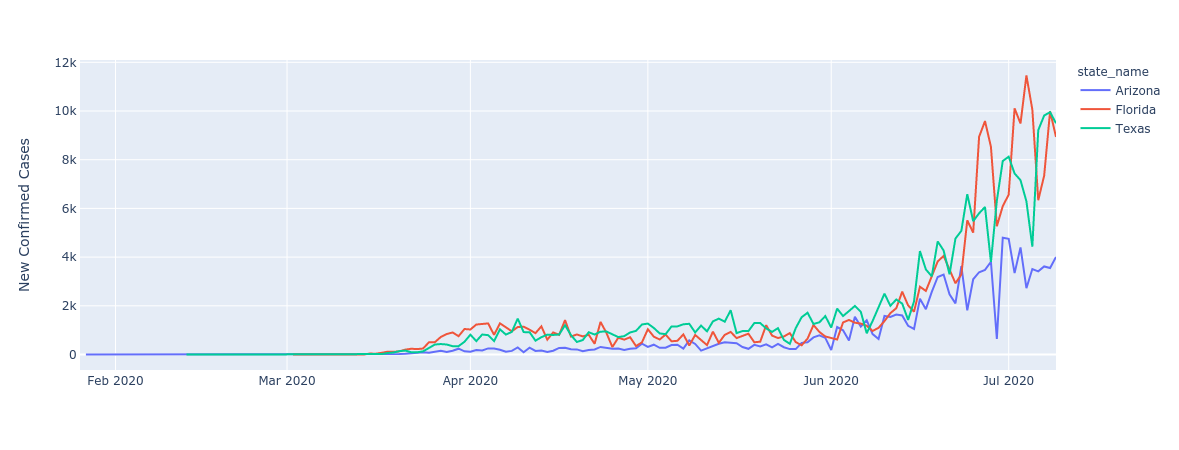

In [112]:
#covid_us_states_daily_changes_wide_2_states = covid_us_states_daily_changes_wide[['Texas', 'Florida']]
#'Virginia|California|New York|Texas|Florida|Arizona|Maryland'
covid_us_states_daily_changes_2_states = covid_us_states_daily_changes[covid_us_states_daily_changes['state_name'].str.contains('Arizona|Texas|Florida')]

# draw a timeseries chart
import plotly.express as px


fig = px.line(covid_us_states_daily_changes_2_states, x='date', y='new_confirmed_cases', color='state_name')
fig.update_layout(yaxis_title="New Confirmed Cases",
                  xaxis_title="")
fig.show()

In [113]:
covid_us_states_daily_changes_2_states_wide = covid_us_states_daily_changes_2_states.pivot(index='date', columns='state_name',values='new_confirmed_cases')
covid_us_states_daily_changes_2_states_wide = covid_us_states_daily_changes_2_states_wide.fillna(0)
covid_us_states_daily_changes_2_states_wide

state_name,Arizona,Florida,Texas
date,,,
2020-01-26,0.0,0.0,0.0
2020-01-27,0.0,0.0,0.0
2020-01-28,0.0,0.0,0.0
2020-01-29,0.0,0.0,0.0
2020-01-30,0.0,0.0,0.0
...,...,...,...
2020-07-05,3510.0,10059.0,4430.0
2020-07-06,3416.0,6336.0,9213.0
2020-07-07,3617.0,7347.0,9814.0


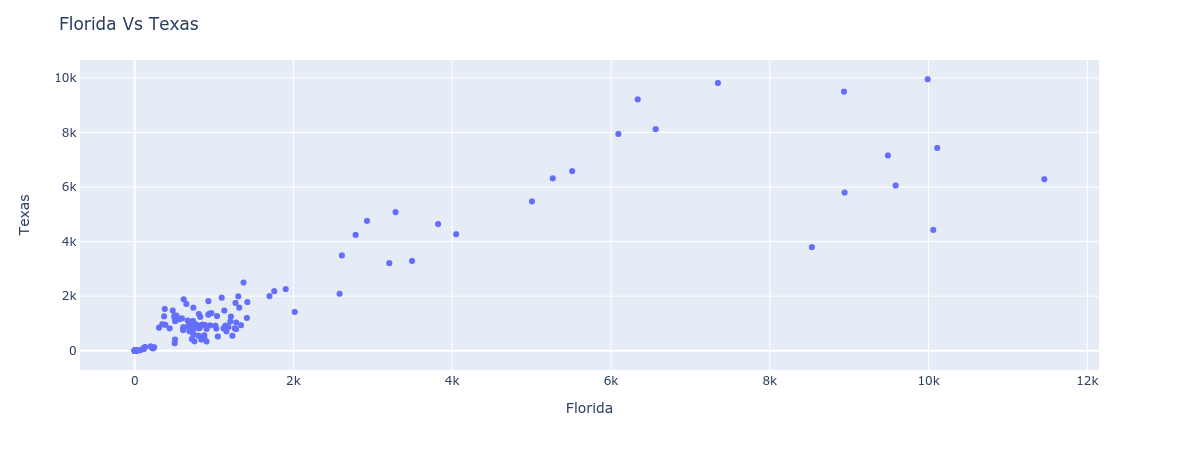

In [114]:
# make a scatter plot
import plotly.express as px
fig = px.scatter(x=covid_us_states_daily_changes_2_states_wide['Florida'], y=covid_us_states_daily_changes_2_states_wide['Texas'])
fig.update_layout(title="Florida Vs Texas",
                  yaxis_title="Texas",
                  xaxis_title="Florida")
fig.show()

In [115]:
overall_pearson_r = covid_us_states_daily_changes_2_states_wide.corr()
overall_pearson_r

state_name,Arizona,Florida,Texas
state_name,,,
Arizona,1.000000,0.892683,0.919400
Florida,0.892683,1.000000,0.906373
Texas,0.919400,0.906373,1.000000


## Lets find the correlation in the response across all states
Calculate the correlation coefficient. Remeber that the data is already sorted by date.

In [116]:
overall_pearson_r = covid_us_states_daily_changes_wide.corr()
overall_pearson_r

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Alabama,1.000000,0.739753,0.755887,0.802055,0.829849,-0.043700,-0.339454,0.017730,-0.270763,0.777148,...,0.801058,0.822938,0.833681,-0.199136,0.246769,0.224905,0.485239,0.567246,0.461106,0.586545
Alaska,0.739753,1.000000,0.832733,0.776948,0.809768,-0.116086,-0.375082,-0.151642,-0.413156,0.832549,...,0.744370,0.800732,0.796635,0.049070,0.357893,-0.045847,0.487830,0.549054,0.405864,0.551861
Arizona,0.755887,0.832733,1.000000,0.830042,0.901233,-0.014000,-0.387698,-0.076379,-0.323255,0.881153,...,0.779840,0.915561,0.872553,-0.195016,0.322876,0.122581,0.598124,0.540699,0.546653,0.593699
Arkansas,0.802055,0.776948,0.830042,1.000000,0.819736,-0.083055,-0.388318,-0.064608,-0.327798,0.787865,...,0.744559,0.794141,0.867477,-0.187504,0.192325,0.191047,0.439653,0.483834,0.428829,0.544807
California,0.829849,0.809768,0.901233,0.819736,1.000000,0.133880,-0.298332,0.041693,-0.181534,0.885687,...,0.861902,0.943173,0.906433,-0.200844,0.377985,0.277731,0.695968,0.604061,0.606129,0.618369
Colorado,-0.043700,-0.116086,-0.014000,-0.083055,0.133880,1.000000,0.517284,0.476684,0.641720,0.058163,...,0.184171,0.085071,0.120526,0.147842,0.085027,0.429127,0.226501,0.103633,0.190613,0.198539
Connecticut,-0.339454,-0.375082,-0.387698,-0.388318,-0.298332,0.517284,1.000000,0.443019,0.581510,-0.311894,...,-0.227227,-0.318429,-0.327417,0.209123,-0.139306,0.173328,-0.135561,-0.165208,-0.152747,-0.136263
Delaware,0.017730,-0.151642,-0.076379,-0.064608,0.041693,0.476684,0.443019,1.000000,0.533888,-0.008835,...,0.085736,-0.007628,-0.029932,-0.092067,-0.065041,0.378925,0.016194,0.060202,0.042964,0.141508
District of Columbia,-0.270763,-0.413156,-0.323255,-0.327798,-0.181534,0.641720,0.581510,0.533888,1.000000,-0.289739,...,-0.076057,-0.251694,-0.201812,0.094587,-0.156364,0.540999,-0.105045,-0.116259,0.067190,-0.166959
Florida,0.777148,0.832549,0.881153,0.787865,0.885687,0.058163,-0.311894,-0.008835,-0.289739,1.000000,...,0.815610,0.896014,0.820480,-0.081973,0.391694,0.083862,0.568902,0.666372,0.435492,0.613148


In [117]:
overall_pearson_r.style.background_gradient(cmap='coolwarm')

Mark states Republican or Democratic based on Governors.

In [118]:
us_states_governers = pd.read_csv("us_states_governers.csv")
us_states_governers.head()

,State,Governor
0,California,Democratic
1,Colorado,Democratic
2,Connecticut,Democratic
3,Delaware,Democratic
4,Hawaii,Democratic


In [119]:
covid_us_states_daily_changes = covid_us_states_daily_changes.merge(us_states_governers, how='left', left_on='state_name', right_on='State')
covid_us_states_daily_changes

,date,state_name,state_fips_code,confirmed_cases,deaths,deaths_yesterday,new_deaths,confirmed_cases_yesterday,new_confirmed_cases,State,Governor
0,2020-03-13,Alabama,01,6,0,NaN,NaN,NaN,NaN,Alabama,Republican
1,2020-03-14,Alabama,01,12,0,0.0,0.0,6.0,6.0,Alabama,Republican
2,2020-03-15,Alabama,01,23,0,0.0,0.0,12.0,11.0,Alabama,Republican
3,2020-03-16,Alabama,01,29,0,0.0,0.0,23.0,6.0,Alabama,Republican
4,2020-03-17,Alabama,01,39,0,0.0,0.0,29.0,10.0,Alabama,Republican
...,...,...,...,...,...,...,...,...,...,...,...
7104,2020-07-05,Wyoming,56,1634,20,20.0,0.0,1606.0,28.0,Wyoming,Republican
7105,2020-07-06,Wyoming,56,1675,20,20.0,0.0,1634.0,41.0,Wyoming,Republican
7106,2020-07-07,Wyoming,56,1711,21,20.0,1.0,1675.0,36.0,Wyoming,Republican
7107,2020-07-08,Wyoming,56,1740,21,21.0,0.0,1711.0,29.0,Wyoming,Republican


### Republican States

In [120]:
covid_us_states_daily_changes_red = covid_us_states_daily_changes[covid_us_states_daily_changes['Governor'] == 'Republican']
covid_us_states_daily_changes_red_wide = covid_us_states_daily_changes_red[['date', 'state_name', 'new_confirmed_cases']].pivot(index='date', columns='state_name',values='new_confirmed_cases').reset_index(drop=True)
covid_us_states_daily_changes_red_wide = covid_us_states_daily_changes_red_wide.fillna(0)
covid_us_states_daily_changes_red_wide.to_csv('covid_us_states_daily_changes_red_wide.csv', index=False)
covid_us_states_daily_changes_red_wide = pd.read_csv('covid_us_states_daily_changes_red_wide.csv')
covid_us_states_daily_changes_red_wide

,Alabama,Alaska,Arizona,Arkansas,Florida,Georgia,Idaho,Indiana,Iowa,Maryland,...,Ohio,Oklahoma,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,West Virginia,Wyoming
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,1091.0,32.0,3510.0,605.0,10059.0,1897.0,368.0,575.0,445.0,233.0,...,968.0,283.0,1461.0,35.0,1133.0,4430.0,288.0,11.0,130.0,28.0
162,925.0,30.0,3416.0,439.0,6336.0,1526.0,423.0,357.0,152.0,540.0,...,805.0,434.0,1533.0,42.0,1144.0,9213.0,648.0,2.0,107.0,41.0
163,907.0,22.0,3617.0,259.0,7347.0,2692.0,360.0,299.0,389.0,489.0,...,948.0,858.0,972.0,58.0,1134.0,9814.0,550.0,3.0,63.0,36.0
164,1177.0,49.0,3551.0,734.0,9989.0,2831.0,422.0,450.0,563.0,469.0,...,1277.0,673.0,1557.0,79.0,2113.0,9952.0,718.0,2.0,202.0,29.0


In [121]:
overall_pearson_r = covid_us_states_daily_changes_red_wide.corr()
overall_pearson_r

,Alabama,Alaska,Arizona,Arkansas,Florida,Georgia,Idaho,Indiana,Iowa,Maryland,...,Ohio,Oklahoma,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,West Virginia,Wyoming
Alabama,1.000000,0.798722,0.795874,0.849427,0.810842,0.816023,0.781697,0.447580,0.597210,0.303833,...,0.711937,0.805791,0.880619,0.389114,0.853608,0.857229,0.878858,0.051629,0.693974,0.703266
Alaska,0.798722,1.000000,0.858338,0.824113,0.856901,0.827618,0.810507,0.313705,0.445843,0.114454,...,0.616035,0.810039,0.890087,0.239131,0.801896,0.837602,0.841746,0.223395,0.665948,0.660611
Arizona,0.795874,0.858338,1.000000,0.854902,0.892683,0.824176,0.828401,0.290990,0.482513,0.107901,...,0.647569,0.879921,0.941577,0.249759,0.806797,0.919400,0.878924,-0.037505,0.635432,0.664457
Arkansas,0.849427,0.824113,0.854902,1.000000,0.818665,0.792014,0.733654,0.375753,0.562608,0.235575,...,0.662651,0.797289,0.894306,0.313798,0.804197,0.831992,0.897274,0.034101,0.626691,0.658780
Florida,0.810842,0.856901,0.892683,0.818665,1.000000,0.871231,0.909880,0.312447,0.482114,0.088779,...,0.686900,0.874888,0.948414,0.241040,0.835033,0.906373,0.834549,0.057483,0.728401,0.676644
Georgia,0.816023,0.827618,0.824176,0.792014,0.871231,1.000000,0.850230,0.545773,0.635745,0.367101,...,0.809096,0.879328,0.875048,0.431293,0.870298,0.893905,0.843730,0.143319,0.760940,0.711633
Idaho,0.781697,0.810507,0.828401,0.733654,0.909880,0.850230,1.000000,0.286804,0.403731,0.073706,...,0.651995,0.869838,0.884436,0.194455,0.815512,0.909588,0.787665,0.119944,0.741714,0.713744
Indiana,0.447580,0.313705,0.290990,0.375753,0.312447,0.545773,0.286804,1.000000,0.772138,0.863743,...,0.757924,0.402975,0.330406,0.706729,0.502702,0.340542,0.483715,0.278894,0.521804,0.513498
Iowa,0.597210,0.445843,0.482513,0.562608,0.482114,0.635745,0.403731,0.772138,1.000000,0.723950,...,0.770274,0.546780,0.514193,0.593388,0.648327,0.533263,0.620078,0.013893,0.553090,0.486666
Maryland,0.303833,0.114454,0.107901,0.235575,0.088779,0.367101,0.073706,0.863743,0.723950,1.000000,...,0.618040,0.210401,0.127015,0.709905,0.365458,0.185761,0.335520,0.133163,0.351615,0.318534


In [122]:
overall_pearson_r.style.background_gradient(cmap='coolwarm')

,Alabama,Alaska,Arizona,Arkansas,Florida,Georgia,Idaho,Indiana,Iowa,Maryland,Massachusetts,Mississippi,Missouri,Nebraska,New Hampshire,North Dakota,Ohio,Oklahoma,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,West Virginia,Wyoming
Alabama,1.000000,0.798722,0.795874,0.849427,0.810842,0.816023,0.781697,0.447580,0.597210,0.303833,0.009970,0.753505,0.808729,0.380988,0.197778,0.533369,0.711937,0.805791,0.880619,0.389114,0.853608,0.857229,0.878858,0.051629,0.693974,0.703266
Alaska,0.798722,1.000000,0.858338,0.824113,0.856901,0.827618,0.810507,0.313705,0.445843,0.114454,-0.084188,0.696131,0.775537,0.149594,0.080069,0.332069,0.616035,0.810039,0.890087,0.239131,0.801896,0.837602,0.841746,0.223395,0.665948,0.660611
Arizona,0.795874,0.858338,1.000000,0.854902,0.892683,0.824176,0.828401,0.290990,0.482513,0.107901,-0.160185,0.698167,0.759667,0.233940,0.021948,0.374567,0.647569,0.879921,0.941577,0.249759,0.806797,0.919400,0.878924,-0.037505,0.635432,0.664457
Arkansas,0.849427,0.824113,0.854902,1.000000,0.818665,0.792014,0.733654,0.375753,0.562608,0.235575,-0.074400,0.721940,0.743374,0.299010,0.121852,0.472286,0.662651,0.797289,0.894306,0.313798,0.804197,0.831992,0.897274,0.034101,0.626691,0.658780
Florida,0.810842,0.856901,0.892683,0.818665,1.000000,0.871231,0.909880,0.312447,0.482114,0.088779,-0.096607,0.707016,0.775780,0.190215,0.013172,0.387526,0.686900,0.874888,0.948414,0.241040,0.835033,0.906373,0.834549,0.057483,0.728401,0.676644
Georgia,0.816023,0.827618,0.824176,0.792014,0.871231,1.000000,0.850230,0.545773,0.635745,0.367101,0.155478,0.804316,0.873286,0.394278,0.285907,0.536420,0.809096,0.879328,0.875048,0.431293,0.870298,0.893905,0.843730,0.143319,0.760940,0.711633
Idaho,0.781697,0.810507,0.828401,0.733654,0.909880,0.850230,1.000000,0.286804,0.403731,0.073706,-0.065756,0.719958,0.806134,0.149624,0.010339,0.361853,0.651995,0.869838,0.884436,0.194455,0.815512,0.909588,0.787665,0.119944,0.741714,0.713744
Indiana,0.447580,0.313705,0.290990,0.375753,0.312447,0.545773,0.286804,1.000000,0.772138,0.863743,0.691477,0.526707,0.598591,0.796752,0.838171,0.753616,0.757924,0.402975,0.330406,0.706729,0.502702,0.340542,0.483715,0.278894,0.521804,0.513498
Iowa,0.597210,0.445843,0.482513,0.562608,0.482114,0.635745,0.403731,0.772138,1.000000,0.723950,0.400617,0.642309,0.644530,0.789840,0.661756,0.720541,0.770274,0.546780,0.514193,0.593388,0.648327,0.533263,0.620078,0.013893,0.553090,0.486666
Maryland,0.303833,0.114454,0.107901,0.235575,0.088779,0.367101,0.073706,0.863743,0.723950,1.000000,0.651566,0.417415,0.428755,0.830788,0.860998,0.713187,0.618040,0.210401,0.127015,0.709905,0.365458,0.185761,0.335520,0.133163,0.351615,0.318534


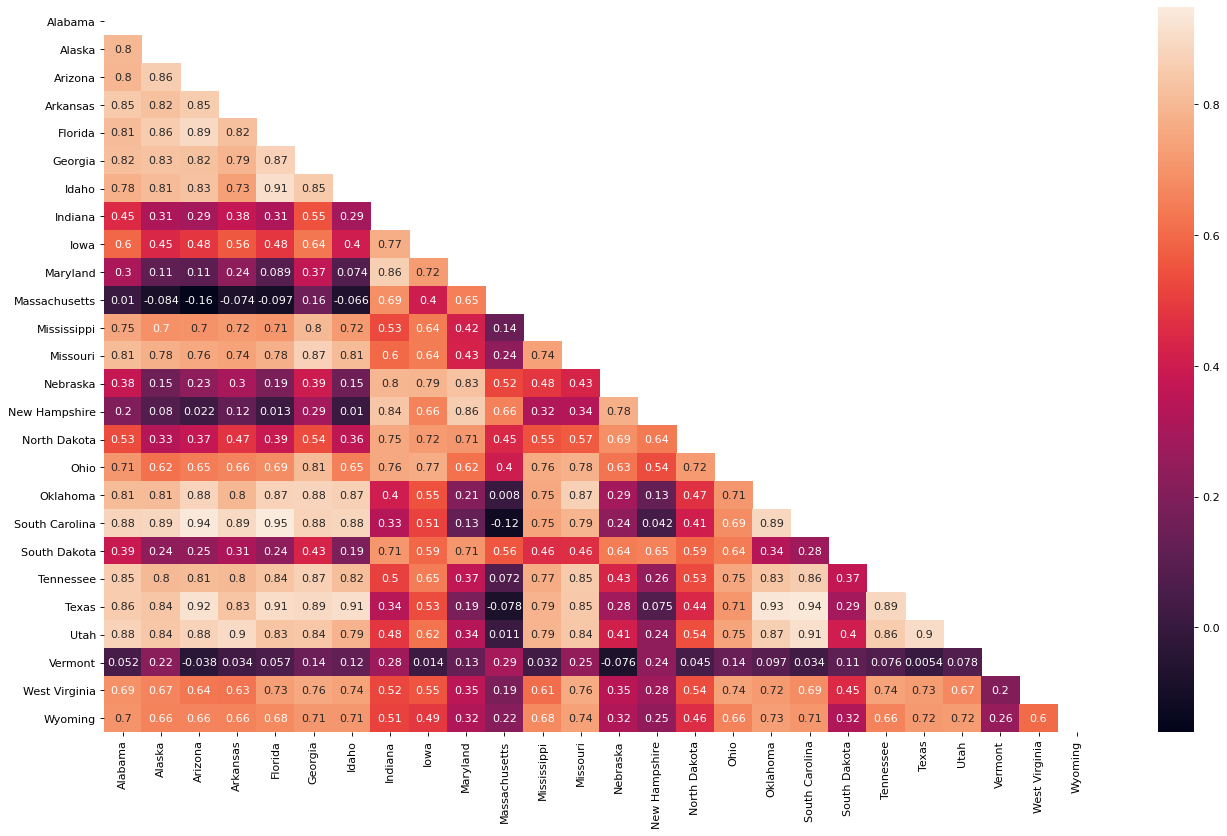

In [123]:
#sns.heatmap(overall_pearson_r)
import numpy as np
fig=plt.figure(figsize=(20, 12), dpi= 80, facecolor='w', edgecolor='k')

matrix = np.triu(overall_pearson_r)
sns.heatmap(overall_pearson_r, annot=True, mask=matrix)

What is the average correlation of each red state with the rest of the red states?

In [124]:
np.mean(overall_pearson_r)

Alabama           0.642753
Alaska            0.591765
Arizona           0.594239
Arkansas          0.609687
Florida           0.608091
Georgia           0.684546
Idaho             0.590371
Indiana           0.548209
Iowa              0.586361
Maryland          0.428352
Massachusetts     0.230402
Mississippi       0.626695
Missouri          0.681837
Nebraska          0.447871
New Hampshire     0.366046
North Dakota      0.531506
Ohio              0.675175
Oklahoma          0.642855
South Carolina    0.630532
South Dakota      0.447248
Tennessee         0.663572
Texas             0.641707
Utah              0.669399
Vermont           0.146156
West Virginia     0.598163
Wyoming           0.582351
dtype: float64

What is the overall average correlation of all red states with all other red states?

In [125]:

np.mean(np.mean(overall_pearson_r))

0.5563803828460425

## Blue States

In [126]:
covid_us_states_daily_changes_blue = covid_us_states_daily_changes[covid_us_states_daily_changes['Governor'] == 'Democratic']
covid_us_states_daily_changes_blue_wide = covid_us_states_daily_changes_blue[['date', 'state_name', 'new_confirmed_cases']].pivot(index='date', columns='state_name',values='new_confirmed_cases').reset_index(drop=True)
covid_us_states_daily_changes_blue_wide = covid_us_states_daily_changes_blue_wide.fillna(0)
covid_us_states_daily_changes_blue_wide.to_csv('covid_us_states_daily_changes_blue_wide.csv', index=False)
covid_us_states_daily_changes_blue_wide = pd.read_csv('covid_us_states_daily_changes_blue_wide.csv')
covid_us_states_daily_changes_blue_wide

,California,Colorado,Connecticut,Delaware,Hawaii,Illinois,Kansas,Kentucky,Louisiana,Maine,...,New Jersey,New Mexico,New York,North Carolina,Oregon,Pennsylvania,Rhode Island,Virginia,Washington,Wisconsin
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,6411.0,200.0,0.0,132.0,24.0,579.0,124.0,3.0,1937.0,18.0,...,369.0,193.0,536.0,1360.0,300.0,481.0,0.0,639.0,669.0,507.0
167,6282.0,216.0,259.0,165.0,7.0,698.0,793.0,752.0,1101.0,8.0,...,209.0,251.0,516.0,1836.0,165.0,784.0,0.0,354.0,1049.0,568.0
168,9897.0,401.0,57.0,121.0,41.0,682.0,75.0,356.0,1936.0,17.0,...,267.0,220.0,590.0,1328.0,210.0,799.0,163.0,638.0,546.0,516.0
169,8538.0,468.0,75.0,48.0,23.0,945.0,650.0,384.0,1888.0,20.0,...,252.0,290.0,691.0,1477.0,212.0,831.0,50.0,635.0,598.0,692.0


In [127]:
overall_pearson_r = covid_us_states_daily_changes_blue_wide.corr()
overall_pearson_r

,California,Colorado,Connecticut,Delaware,Hawaii,Illinois,Kansas,Kentucky,Louisiana,Maine,...,New Jersey,New Mexico,New York,North Carolina,Oregon,Pennsylvania,Rhode Island,Virginia,Washington,Wisconsin
California,1.000000,0.422580,0.019039,0.333630,0.467945,0.262411,0.597690,0.663078,0.627319,0.467047,...,-0.013554,0.789955,-0.081125,0.889294,0.874276,0.289838,0.110004,0.508074,0.703531,0.632803
Colorado,0.422580,1.000000,0.655724,0.681916,0.363381,0.818238,0.517546,0.589649,0.476410,0.691642,...,0.696060,0.676200,0.624564,0.411333,0.398631,0.861206,0.791035,0.680177,0.565671,0.444739
Connecticut,0.019039,0.655724,1.000000,0.595711,0.186993,0.647560,0.233843,0.262975,0.258250,0.436465,...,0.781216,0.331953,0.688893,0.003936,0.027404,0.787558,0.779264,0.419513,0.227299,0.115687
Delaware,0.333630,0.681916,0.595711,1.000000,0.149850,0.761472,0.420705,0.483982,0.314233,0.524314,...,0.528800,0.555529,0.370816,0.328592,0.284321,0.705444,0.681248,0.609910,0.398119,0.321111
Hawaii,0.467945,0.363381,0.186993,0.149850,1.000000,0.046858,0.174076,0.283449,0.654327,0.310401,...,0.391778,0.303048,0.506709,0.375791,0.562776,0.371604,0.044899,0.064493,0.575879,0.228074
Illinois,0.262411,0.818238,0.647560,0.761472,0.046858,1.000000,0.493665,0.539609,0.258389,0.670590,...,0.585301,0.639945,0.424915,0.294650,0.211013,0.784086,0.794077,0.770509,0.373516,0.393436
Kansas,0.597690,0.517546,0.233843,0.420705,0.174076,0.493665,1.000000,0.645660,0.407130,0.397446,...,0.181265,0.681638,0.082298,0.587292,0.550551,0.459428,0.355036,0.463428,0.588441,0.471388
Kentucky,0.663078,0.589649,0.262975,0.483982,0.283449,0.539609,0.645660,1.000000,0.469647,0.510009,...,0.253221,0.743397,0.128288,0.694587,0.555929,0.502360,0.371789,0.619514,0.643646,0.533102
Louisiana,0.627319,0.476410,0.258250,0.314233,0.654327,0.258389,0.407130,0.469647,1.000000,0.408607,...,0.366933,0.495470,0.390118,0.533611,0.633357,0.500139,0.183907,0.318984,0.693097,0.397941
Maine,0.467047,0.691642,0.436465,0.524314,0.310401,0.670590,0.397446,0.510009,0.408607,1.000000,...,0.405360,0.655289,0.339646,0.576518,0.416020,0.584557,0.495835,0.733941,0.492485,0.548473


In [128]:
overall_pearson_r.style.background_gradient(cmap='coolwarm')

,California,Colorado,Connecticut,Delaware,Hawaii,Illinois,Kansas,Kentucky,Louisiana,Maine,Michigan,Minnesota,Montana,Nevada,New Jersey,New Mexico,New York,North Carolina,Oregon,Pennsylvania,Rhode Island,Virginia,Washington,Wisconsin
California,1.000000,0.422580,0.019039,0.333630,0.467945,0.262411,0.597690,0.663078,0.627319,0.467047,0.192304,0.558045,0.777740,0.902799,-0.013554,0.789955,-0.081125,0.889294,0.874276,0.289838,0.110004,0.508074,0.703531,0.632803
Colorado,0.422580,1.000000,0.655724,0.681916,0.363381,0.818238,0.517546,0.589649,0.476410,0.691642,0.612938,0.589344,0.287113,0.352201,0.696060,0.676200,0.624564,0.411333,0.398631,0.861206,0.791035,0.680177,0.565671,0.444739
Connecticut,0.019039,0.655724,1.000000,0.595711,0.186993,0.647560,0.233843,0.262975,0.258250,0.436465,0.579967,0.251505,-0.050387,0.001772,0.781216,0.331953,0.688893,0.003936,0.027404,0.787558,0.779264,0.419513,0.227299,0.115687
Delaware,0.333630,0.681916,0.595711,1.000000,0.149850,0.761472,0.420705,0.483982,0.314233,0.524314,0.409245,0.561921,0.128021,0.294123,0.528800,0.555529,0.370816,0.328592,0.284321,0.705444,0.681248,0.609910,0.398119,0.321111
Hawaii,0.467945,0.363381,0.186993,0.149850,1.000000,0.046858,0.174076,0.283449,0.654327,0.310401,0.467826,0.019164,0.684490,0.553362,0.391778,0.303048,0.506709,0.375791,0.562776,0.371604,0.044899,0.064493,0.575879,0.228074
Illinois,0.262411,0.818238,0.647560,0.761472,0.046858,1.000000,0.493665,0.539609,0.258389,0.670590,0.494069,0.739816,0.001988,0.172157,0.585301,0.639945,0.424915,0.294650,0.211013,0.784086,0.794077,0.770509,0.373516,0.393436
Kansas,0.597690,0.517546,0.233843,0.420705,0.174076,0.493665,1.000000,0.645660,0.407130,0.397446,0.246483,0.529787,0.365033,0.494916,0.181265,0.681638,0.082298,0.587292,0.550551,0.459428,0.355036,0.463428,0.588441,0.471388
Kentucky,0.663078,0.589649,0.262975,0.483982,0.283449,0.539609,0.645660,1.000000,0.469647,0.510009,0.355419,0.629876,0.430723,0.528068,0.253221,0.743397,0.128288,0.694587,0.555929,0.502360,0.371789,0.619514,0.643646,0.533102
Louisiana,0.627319,0.476410,0.258250,0.314233,0.654327,0.258389,0.407130,0.469647,1.000000,0.408607,0.450452,0.299918,0.680710,0.604974,0.366933,0.495470,0.390118,0.533611,0.633357,0.500139,0.183907,0.318984,0.693097,0.397941
Maine,0.467047,0.691642,0.436465,0.524314,0.310401,0.670590,0.397446,0.510009,0.408607,1.000000,0.464149,0.703715,0.262930,0.414899,0.405360,0.655289,0.339646,0.576518,0.416020,0.584557,0.495835,0.733941,0.492485,0.548473


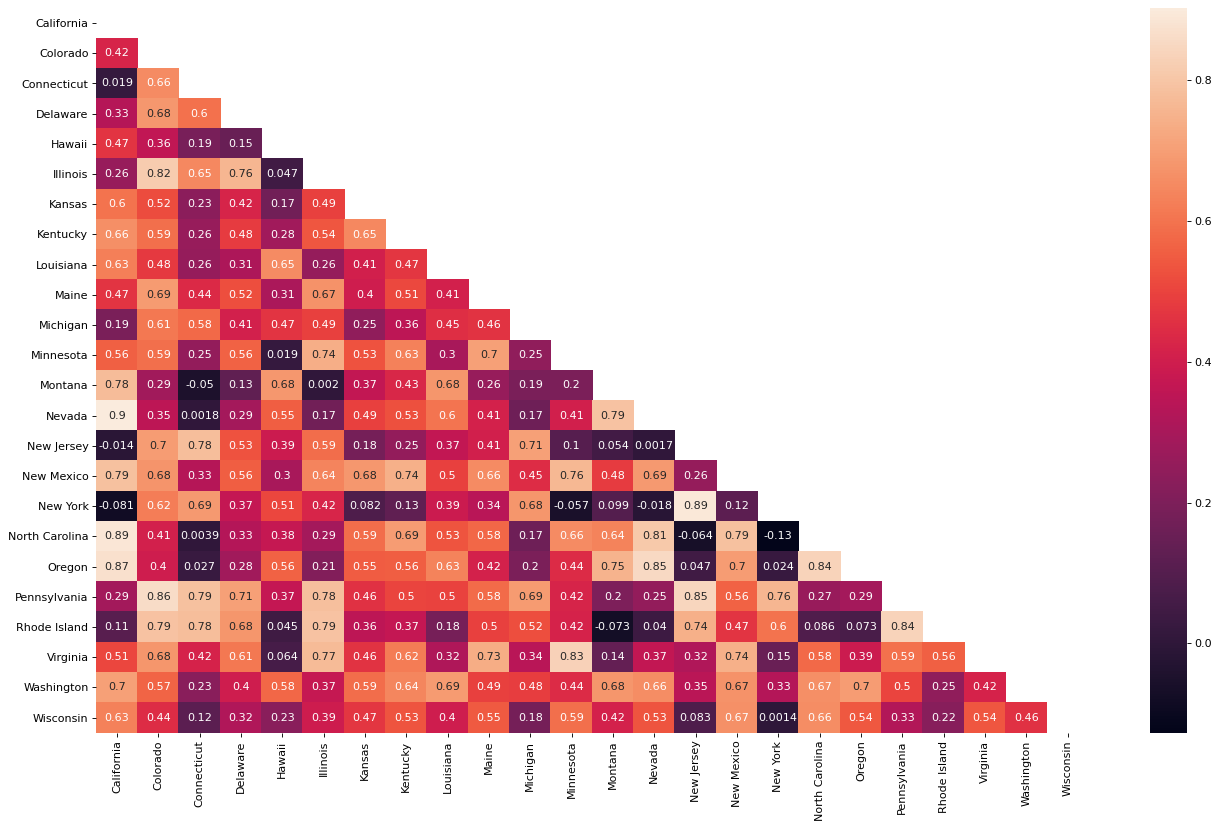

In [129]:
#sns.heatmap(overall_pearson_r)
import numpy as np
fig=plt.figure(figsize=(20, 12), dpi= 80, facecolor='w', edgecolor='k')

matrix = np.triu(overall_pearson_r)
sns.heatmap(overall_pearson_r, annot=True, mask=matrix)

In [130]:

np.mean(np.mean(overall_pearson_r))

0.46977850926638104